# Measuring the Stark Shift: <mark>Ramsey Experiment</mark>
1. **Introduction**
2. **Problem parameters**
3. **Setting up operators, Hamiltonian's, and the initial state**
4. **Generating a pulse waves**
    * CASE I: No thermal losses considered
    * CASE II: Thermal losses considered
5. **Results**
    * Final state, Fidelity, Concurrence

**Author** : Soumya Shreeram (shreeramsoumya@gmail.com)<br>
**Supervisor** : Yu-Chin Chao (ychao@fnal.gov) <br>
**Date**: 16th August 2019<br>

This script was coded as part of the Helen Edwards Summer Internship program at Fermilab. The script measures the Stark Shift between the single photon in a qubit and the lowest filter mode.

## 1. Introduction

A multi-mode QED architecture is explored as described in by [McKay et *al*](http://schusterlab.uchicago.edu/static/pdfs/McKay2015.pdf). The hamiltonian for such a system with two qubits with frequencies $v_{Q,1}$, $v_{Q,2}$, and $n$ mode filter can be described as the sum of the qubit Hamiltonian, $\hat{H}_Q$, the filter Hamiltonian, $\hat{H}_F$, and the qubit-filter coupling Hamiltonian, $\hat{H}_{Q-F},$
$$ \hat{H} = \hat{H_Q} + \hat{H_F} + \hat{H}_{Q-F} $$

$$ \hat{H_Q} = h\ v_{Q,1}\ \frac{\hat{ \sigma}^z_1}{2} + h\ v_{Q,2}\ \frac{\hat{ \sigma}^z_2}{2}$$

$$ \hat{H}_{F} = \sum_{i=1}^{n}h\ v_{F}\ \hat{a}^{\dagger}_i \hat{a}_i +  \sum_{i=2}^{n}h\ g_{F}\ (\hat{a}^{\dagger}_i \hat{a}_{i-1} + \hat{a}^{\dagger}_{i-1} \hat{a}_i)$$

$$ \hat{H}_{Q-F} = h\ g_{Q1,F}\ (\hat{a}^{\dagger}_1 \hat{\sigma}^-_1 + \hat{a}_1 \hat{\sigma}^+_1) + h\ g_{Q2,F}\ (\hat{a}^{\dagger}_n \hat{\sigma}^-_2 + \hat{a}_n \hat{\sigma}^+_2)$$

where $\hat{\sigma}^{+(-)}$ is the raising and lowering operator for the qubit, $\hat{a}_i$ creates a photon in the $i^{th}$ resonantor, $g_F$ is the filter-filter coupling, and $g_{Q,F}$ is the qubit-filter coupling.

Here we must also account for the interaction of the quantum state with it's environment. This can be represented by a non-Hermitian term in the Hamiltonian such that,
$$\displaystyle H_{\rm eff}(t) = H(t) - \frac{i\hbar}{2}\sum_n c_n^\dagger c_n$$
where $c_n$ is the collapse operator.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
plt.rcParams.update({'font.size': 16})

import numpy as np
from numpy import ones,vstack
from numpy.linalg import lstsq
from math import pi
from scipy.signal import find_peaks

from time import sleep
import sys

from qutip import *

## 2. Problem parameters
Here we use $\hbar=1$; the coupling terms are redefined with a multiple of $2\pi$ before them for convinience.

In [3]:
def generateTimePulse(tr, th, offset):
    """
    Function that generates the pulse based on the input parameters
    @param tr :: ramp up/down time for the pulse
    @param th :: hold time for the pulse
    @return t_pulse :: np array with 4 times that define the pulse
    """
    t_pulse = [0, 0, 0, 0]
    t_pulse[0] = offset
    t_pulse[1] = tr + t_pulse[0]
    t_pulse[2] = t_pulse[1] + th
    t_pulse[3] = t_pulse[2] + tr
    print("The time pulse is: ", t_pulse)
    return t_pulse

In [69]:
"""------------- FREQUENCIES -----------------"""
w_q1 = 2*pi*6.5;     # Qubit 1 frequency
w_q2 = 2*pi*6.8;     # Qubit 2 frequency: range from 1-9 GHz
w_f = 2*pi*7.1;      # Resonator/ Filter frequency

# from notebook on 3 cavities we saw that cavity splits into 3 levels
w_f1 = 2*pi*6.933
w_f2 = 2*pi*7.1
w_f3 = 2*pi*7.2668
"""------------- COUPLING --------------------"""
g_f1 = 2*pi*0.118    # Filter-filter coupling
#g_f2 = 2*pi*0.344 
g_q1f = 2*pi*0.135   # qubit 1-fitler coupling
#g_q2f = 2*pi*0.415   # qubit 2-fitler coupling

numF = 3             # number of filters
N = 2                # number of fock states 

end_point =200
data_points = 1500
times = np.linspace(0, 250, 1500)

"""------------- DISSIPATION PARAMETERS -----"""
kappa = 5*10**-3        # cavity dissipation rate
n_th_a = 3*10**-3       # avg. no. of thermal bath excitation
r1 = 5*10**-6           # qubit relaxation rate
r2 = 1*10**-5           # qubit dephasing rate

"""------------- PULSE CONTROL PARAMETERS -----"""
tr = [10, 5]             # ramp up and ramp down times for q1, q2
th = [160, 10]          # hold time for q1, q2
t_pulse = generateTimePulse(tr[0], th[0], 0)
t_pulse1 = generateTimePulse(tr[1], th[1], 20)

# amplitude to raise/lower pulse above cavity frequency [q1, q2]
d = [0.25, 0.2]  

w_top = [w_f + 2*pi*d[0], w_f - 2*pi*d[1]]
no_ramps = 100        # number of ramps pulses sent into the Hamiltonian

The time pulse is:  [0, 10, 170, 180]
The time pulse is:  [20, 25, 35, 40]


## 3. Setting up the operators, Hamiltonian's, and Initial state

For every qubit: <br> <br>
**sm** $\ \rightarrow \ \hat{\sigma}^{+(-)}$ is the raising and lowering operator of the *qubit* <br>
**sz** $\ \ \rightarrow \ \sigma_z $ is the Pauli-z matrix of the *qubit* <br>
**n** $\ \ \ \rightarrow \ n$ is the number operator

In [47]:
def numOp(m):
  """
  Computes the number operator 
  @param loweringMat :: lowering matrix operator for a system
  """
  return m.dag()*m

def rwaCoupling(m1, m2):
    return m1.dag()*m2 + m2.dag()*m1

def setXYlabel(ax, x, y, req_title, title_):
    """
    Generic function to set labels for plots
    """
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    if req_title == True:
        ax.set_title(title_)
    return 

### 3.1 Operators 

In [6]:
# cavity 1, 2, 3 destruction operators
a1 = tensor(destroy(N), qeye(N), qeye(N), qeye(2), qeye(2))
a2 = tensor(qeye(N), destroy(N), qeye(N), qeye(2), qeye(2))
a3 = tensor(qeye(N), qeye(N), destroy(N), qeye(2), qeye(2))

# operators for qubit 1 
sm1 = tensor(qeye(N), qeye(N), qeye(N), sigmam(), qeye(2))
sz1 = tensor(qeye(N), qeye(N), qeye(N), sigmaz(), qeye(2))    
n1 = sm1.dag() * sm1

# operators for qubit 2
sm2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), sigmam())
sz2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), sigmaz())
n2 = sm2.dag() * sm2

In [7]:
# collapse operators
c_ops = []

# cavity relaxation
rate = kappa * (1 + n_th_a)
c_ops.append(np.sqrt(rate) * a1)
    
# cavity excitation

# qubit 1 relaxation
c_ops.append(np.sqrt(r1 * (1+n_th_a)) * sm1)
c_ops.append(np.sqrt(r1 * n_th_a) * sm1.dag())
c_ops.append(np.sqrt(r2) * sz1)

# qubit 2 relaxation
c_ops.append(np.sqrt(r1 * (1+n_th_a)) * sm2)
c_ops.append(np.sqrt(r1 * n_th_a) * sm2.dag())
c_ops.append(np.sqrt(r2) * sz2)

### 3.2 Hamiltonian's and initial state

In [8]:
# Qubit Hamiltonians (Hq1+Hq2)
Hq1 =  0.5*sz1       
Hq2 =  0.5*sz2

# Filter Hamiltonians (refer formula in the Introduction)
Hf = numOp(a1) + numOp(a2) + numOp(a3)    
H_f12 = g_f1*(rwaCoupling(a1, a2) + rwaCoupling(a2, a3))

# Qubit-Filter Hamiltonian
Hqf = g_q1f*(rwaCoupling(a1, sm1) + rwaCoupling(a3, sm2))

# time-independent Hamiltonian (see later)
H0 = H_f12 + Hqf + w_f*Hf
 
H = H0 + w_q1*Hq1 + w_q2*Hq2  # Resultant Hamiltonian

### 3.3 Initial State

In [9]:
# initial state of the system. Qubit 1: superposition of ground and excited state, Qubit 2: ground st.
psi0 = tensor(basis(N,0), basis(N,0), basis(N,0), (basis(2,0)+basis(2,1)).unit(), basis(2,1))

## 4. Demonstrating avoided crossing

In this section the qubit frequency is raised above the cavity frequency by applying a linearly varying ramp time $t$ (ns). The signal is held for a time $T-2t$ before it is ramped down again. 

Tranformations on closed quantum states can be modelled by unitary operators. The combined time-dependent Hamiltonian for a system undergoing a tranformation that can be representated as,
$$ H(t) = H_0 + \sum_{i=0}^n c_i(t)H_i$$
where $H_0$ is called the time-independent drift Hamiltonian and $H_i$ are the control Hamiltonians with a time varying amplitude $c_i(t)$.

Here we write the Hamiltonian in a function-based time dependent way. See other ways [here](http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html). Here the time-dependent coefficients, $f_n(t)$ of the Hamiltonian (e.g. `wf_t, w1_t,w2_t`) are expressed using Python functions 

### 4.1 Functions

In [10]:
"""----------------------------------------
                  PULSE FUNCTIONS
------------------------------------------"""
def fitLine(t_pulse, i, j, w1, w2, t):
    """
    Function generates a best fit line between [x1, y1] ->[x2, y2]
    Input:
        @param t_pulse :: np array containing the 4 points parameterizing the pulse
        @param i,j :: indicies of t_pulse determining the start-stop times
        @param w1, w2 :: lower and higher frequencies of the ramp pulse
        @param t :: interable time variable
    Returns:
        @polynomial(t) :: best-fit y value at t
    """
    # compute coefficients
    coefficients = np.polyfit([t_pulse[i], t_pulse[j]], [w1, w2], 1) 
    # generate best-fit polynmial
    polynomial = np.poly1d(coefficients)    
    return polynomial(t)

def rampUp(t_pulse, w1, w2, t):
    """
    Generating a ramp up pulse
    Input:
        @param t_pulse :: np array containing the 4 points parameterizing the pulse
        @param w1, w2 :: lower and higher frequencies of the ramp pulse
        @param t :: interable time variable
    Returns:
        @param w :: int giving the y-value based on t
    """
    t0 = t_pulse[0]
    t1 = t_pulse[1]
    if t0 != t1:
        if t < t1:
            return w1 + fitLine(t_pulse, 0, 1, 0, (w2-w1), t)*(t>t0) 
        if t > t1:
            return w1 + (w2-w1)*(t>t1)
    else:
        return w1 + (w2 - w1)*(t > t1)

def rampDown(t_pulse, w1, w2, t):
    """
    Generating a ramp Down pulse
    Same as the ramp Up pulse given above only with the 
    """
    t2 = t_pulse[2]
    t3 = t_pulse[3]
    if t2 != t3:
        if t > t2:
            return w1 + fitLine(t_pulse, 2, 3, (w2-w1), 0, t)*(t>t2 and t<t3) 
        if t < t2:
            return w1 + (w2-w1)*(t<t2)
    else:
        return w1 + (w2-w1)*(t<t2)

def wq1_t(t, args=None):
    """
    Function defines the time depended co-efficent of the qubit 1
    w_q1(t) is a pulse wave going from 0 to height (w_f-w_q1) at T0_1 
    """
    return (rampUp(t_pulse, w_q1, w_top[0], t) + rampDown(t_pulse, w_q1, w_top[0], t)-w_top[0])

def wq1_tdown(t, args=None):
    """
    Function defines the time depended co-efficent of the qubit 1
    w_q1(t) is a pulse wave going from 0 to height (w_f-w_q1) at T0_1 
    """
    return rampDown(t_pulse, w_q1, w_top, t)

def wf_t(t, args=None):
    """
    Function defines the time depended co-efficent of the filters
    (Although, there is no frequency change of the filters with time)
    so w_f(t) = constant
    """
    return w_f


def wq2_t(t, args=None):
    """
    Function defines the time depended co-efficent of qubit 2
    (Although, there is no frequency change of the quibit 2 with time)
    so w_q2(t) = constant
    """
    return (rampUp(t_pulse1, w_q2, w_top[1], t) + rampDown(t_pulse1, w_q2, w_top[1], t)-w_top[1])

"""---------------------------------------------
                  HAMILTONIAN FUNCTIONS
---------------------------------------------"""
def plotPulse(ax, times, t_pulse, w_q1, w_top, colorCode, label_, ramp):
    """
    Plots the required pulse
    """
    if ramp == True:
        plotting = ax.plot(times, [rampUp(t_pulse, w_q1, w_top, t)/(2*pi) for t in times], colorCode, label=label_)
    elif ramp == False:
        plotting = ax.plot(times, [rampDown(t_pulse, w_q1, w_top, t)/(2*pi) for t in times], colorCode, label=label_)
    if ramp == 'Custom':
        plotting = ax.plot(times, [(rampUp(t_pulse, w_q1, w_top, t) + rampDown(t_pulse, w_q1, w_top, t)-w_top)/(2*pi) for t in times], colorCode, label=r"$\Delta$t = %.1f ns"%(t_pulse[1]-t_pulse[0]))
    return plotting

def labelTimes(t_r, t_H):
    label = r'$(\Delta t_1, t_{\rm H, 1}) = (%.2f, %.2f) {\ \rm ns}$ | $(\Delta t_2, t_{\rm H, 2}) = (%.2f, %.2f) {\ \rm ns}$'%(t_r[0], t_H[0], tr[1], t_H[1])    
    return label

def wf1_t(t, args=None):
    return w_f1
def wf2_t(t, args=None):
    return w_f2
def wf3_t(t, args=None):
    return w_f3

def plotFrequencies(ax, times, wf_t, Colour, labels_, linestyle_):
    """
    Function plots the frequencies as a function of times
    """
    ax.plot(times, np.array(list(map(wf_t, times)))/(2*pi), Colour, linewidth=2, label=labels_, linestyle=linestyle_)
    ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
    return 

def plotProb(ax, times, component, res, Colour, labels_, linestyle_):
    """
    Function plots the occupation probabilities of the components after running mesolve
    """
    ax.plot(times, np.real(expect(component, res.states)), Colour, linewidth=1.5, label=labels_, linestyle=linestyle_)
    ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
    return 

### 4.2 Demonstrating the ramp pulse generated

The figure below demonstrated how the combination of ramping up and down forms the required pulse. 

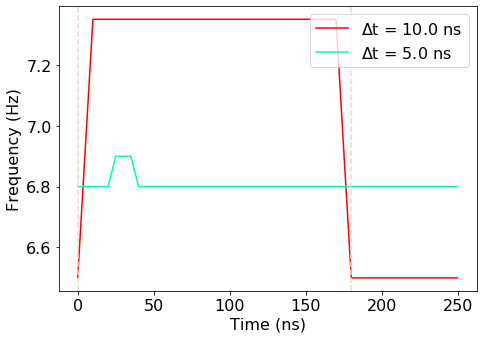

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

# plotting the pulses
plotPulse(ax, times, t_pulse, w_q1, w_top[0], 'r', ' ', 'Custom')
plotPulse(ax, times, t_pulse1, w_q2, w_top[1], '#03fcba', ' ', 'Custom')

# guide lines
ax.axvline(x=t_pulse[0], color='#f2d4c4', linestyle='--')
ax.axvline(x=t_pulse[3], color='#f2d4c4', linestyle='--')

setXYlabel(ax, 'Time (ns)', 'Frequency (Hz)', False, '')
ax.legend(loc="upper right")
fig.tight_layout()

### 4.2 Solving the Master equation and plotting the results (without thermal losses)

In [12]:
opts = Odeoptions(max_step=0.0005, nsteps=50000)

# time dependent Hamiltonian
H_t = [H0, [Hq1, wq1_t], [Hq2, wq2_t]]

# Evolving the system
res = mesolve(H_t, psi0, times, [], [], options=opts)

no collapse operator, using sesolve


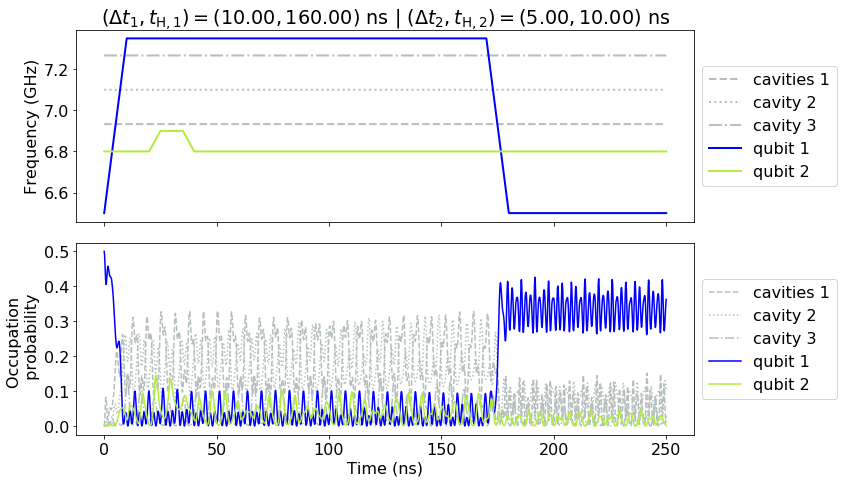

In [13]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,7))

labels_ = ["cavities 1", "cavity 2", "cavity 3", "qubit 1", "qubit 2"]
w_list = [wf1_t, wf2_t, wf3_t, wq1_t, wq2_t]
colors_ = ['#b4bfbc', '#b4bfbc', '#b4bfbc', 'b', '#b0ed3e']
linestyle_ = ['--', ':', '-.', '-', '-']
components_ = [numOp(a1), numOp(a2), numOp(a3), n1, n2]

for i in [0, 1, 2, 3, 4]:
    plotFrequencies(axes[0], times, w_list[i], colors_[i], labels_[i], linestyle_[i])
setLabels(axes[0], tr, th, 0)

for i in [0, 1, 2, 3, 4]:
    plotProb(axes[1], times, components_[i], res, colors_[i], labels_[i], linestyle_[i])
setLabels(axes[1], tr, th, 1)

fig.tight_layout()

## 5. Performing the Ramsey Experiment

In [15]:
def showProgress(idx, n):
    """
    Function prints the progress bar for a running function
    @param idx :: iterating index
    @param n :: total number of iterating variables/ total length
    """
    j = (idx+1)/n
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
    sys.stdout.flush()
    sleep(0.25)
    return 

def findIndex(times, t4):
    """
    Function finds the index in the times array at required point t4
    @param times :: np array contains the times at which H is evaluated
    @param t4 :: the point at which the pulse ends
    @returns param idx_array[0] :: the index of t4 in the times array
    """
    idx_array = []
    for i, t in enumerate(times):
        if t >= t4 and t < t4+1:
            idx_array.append(i)
    return idx_array[0]

def genTimePulses(rampList):
    """
    Generates pulses with variable ramp times
    @param rampList :: List with 
    """
    ramp_vals = np.empty((0, 4))
    for dt in rampList:
        ramp_up_time = t_pulse1[1]-t_pulse1[0]
        t_new = [t_pulse1[0], t_pulse1[1], dt, dt+ramp_up_time]
        ramp_vals = np.append(ramp_vals, [t_new], axis=0)  
    return ramp_vals  

def printShape(ramp_dt_array):
    print("\nDimensions of the resultant 2D array:",   np.shape(ramp_dt_array))
    return 

### 5.1 Changing $\tau$, adding $\pi/2$ pulse and observing the Ramsey Fringe 

No thermal losses have been accounted.

In [71]:
# get the point after the ramp down excitation
t_idx = findIndex(times, t_pulse1[3])

# generating a range of pulse with varying ramp times
rampList = np.linspace(t_pulse1[1], t_pulse[3]-20, no_ramps)

# generates the pulses with varying tau
ramp_vals = genTimePulses(rampList)

# creating an array of v_q2
dv = np.linspace(0.3, w_top[0]-w_q2+1, 10)

### 5.3 Solving the Hamiltonian for every $\tau$ and taking the Fourier transform of the Ramsey fringe 

In [72]:
def FourierTransformOf(rampList, ramp_exp_arr):
    """
    Function calculates the Fourier Transform of the input x-y data
    @param rampLish :: x-values e.g. array of times
    @param ramp_exp_arr :: real valued array whose FFT is calculated
    
    @returns freq_arr :: x-vales in the freqeuncy domain
             power :: Fourier transformed values of input ramp_exp_arr
    """
    # fft of ram_exp_arr
    ramp_FFT = np.fft.rfft(ramp_exp_arr)
    power = np.real(ramp_FFT)*np.real(ramp_FFT)+np.imag(ramp_FFT)*np.imag(ramp_FFT)
    
    # generating the FFT frequency array
    start_pt = 1/rampList[-1]
    freq_arr = np.linspace(start_pt, start_pt*len(power), len(power))
    return freq_arr, power


def storePeakFFTvals(rampList, ramp_exp_arr):
    rampList_FFT, ramp_exp_arr_FFT = FourierTransformOf(rampList, ramp_exp_arr)     
    # find peaks
    peak, _ = find_peaks(ramp_exp_arr_FFT, distance=700) 
    return rampList_FFT[peak]

In [73]:
peak_freq = []
ramsey_fr_arr2D = np.empty((0, no_ramps))
for j,v in enumerate(dv):
    w_top[1]=w_q2+v
    ramsey_fr_arr = []
    for i in range(no_ramps):
        t_pulse1 = ramp_vals[i][:]        

        # time dependent Hamiltonian
        H_t = [H0, [Hq1, wq1_t], [Hq2, wq2_t]]

        # Evolving the system with/without thermal losses
        output = mesolve(H_t, psi0, times, [], [])

        # state after off-resonance of qubit 1
        psi_t3 = output.states[t_idx]

        # applying the pi/2 pulse
        psi_qubits_pi2 = ket2dm(tensor(phasegate(0), phasegate(0), phasegate(0), phasegate(pi/2), phasegate(0)) * psi_t3)

        # measuring the expectation value for every tau
        exp_vals = np.real(expect(n1, psi_qubits_pi2))
        
        # ramsey fringes 
        ramsey_fr_arr.append(exp_vals)

    # store the ramsey fringes
    ramsey_fr_arr2D = np.append(ramsey_fr_arr2D, [ramsey_fr_arr], axis=0)

    # take the FFT
    peak_freq.append(storePeakFFTvals(rampList, ramsey_fr_arr))
    
    # progress bar
    showProgress(j, len(dv))

no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using sesolve
no collapse operator, using 

### 5.3 Plotting and taking the Fourier transform of the Ramsey fringe

In [29]:
def plotFFT(ax, rampList, ramp_exp_arr):
    """
    Function finds the peaks in the FFT spectrum and plots the results
    @param rampList :: x-vales e.g. array of times
    @param ramp_exp_arr :: real valued array whose FFT is calculated
    """
    rampList_FFT, ramp_exp_arr_FFT = FourierTransformOf(rampList, ramp_exp_arr)     
    # find peaks
    peak, _ = find_peaks(ramp_exp_arr_FFT, distance=700)
    
    # plot
    ax.plot(rampList_FFT[1:], ramp_exp_arr_FFT[1:], color='#76bdde', linestyle=':', marker='.',  markeredgecolor='b', markersize=8)
    ax.plot(rampList_FFT[peak], ramp_exp_arr_FFT[peak], 'ro')
    setXYlabel(ax, 'Frequency (GHz)', r'$\mathcal{F}\ [n_1]:$ 3 cavities', True, '(x, y) = (%.1f, %.2f)'%(ramp_exp_arr_FFT[peak], rampList_FFT[peak]))
    fig.tight_layout()
    return ramp_exp_arr_FFT[peak], rampList_FFT[peak]


def printResults(y, x):
    print(' Power value:     ', y)
    print(' Frequency value: ', x)
    return

 Power value:      [9.75328467e-06]
 Frequency value:  [0.14814815]


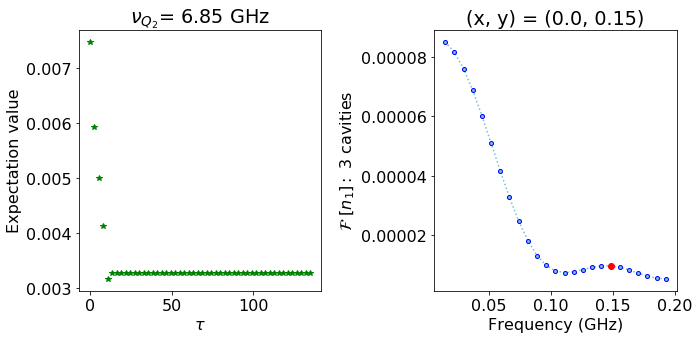

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(rampList-t_pulse1[1], ramsey_fr_arr, 'g*')
setXYlabel(ax[0], r'$\tau$', 'Expectation value', True, r'$\nu_{Q_2}$= %.2f GHz'%(w_top[1]/(2*pi)))

yf_peak, xf_peak = plotFFT(ax[1], rampList-t_pulse1[1], ramsey_fr_arr)
printResults(yf_peak, xf_peak)
fig.tight_layout()

In [20]:
6.85, 0